In [1]:
import scipy.io
import jax.numpy as np
from scipy.io import loadmat 
import numpy as onp
import nibabel as nib
import matplotlib.pyplot as plt 
import os
import shutil
from PIL import Image
from inrmri.bart import bart_acquisition_from_arrays
from inrmri.data_harvard import get_csmaps_and_mask, get_reference_reco
import pandas as pd
from jax import jit, vmap, random
from inrmri.dip import TimeDependant_DIP_Net, helix_generator, circle_generator
from inrmri.new_radon import ForwardRadonOperator
from inrmri.fourier import fastshiftfourier, get_freqs
from inrmri.basic_nn import weighted_loss 
from inrmri.utils import to_complex, is_inside_of_radial_lim, meshgrid_from_subdiv_autolims, total_variation_batch_complex, save_matrix_and_dict_in_zpy, load_matrix_and_dict_from_zpy    
from inrmri.utils import create_exp_file_name, total_variation_complex
import optax 
from inrmri.metrics_rd import mean_psnr, mean_ssim, mean_artifact_power
from inrmri.utils_rdls import seconds_to_min_sec_format, filter_and_get_columns, apply_transform

from inrmri.image_processor import BeforeLinRegNormalizer
from inrmri.basic_plotting import full_halph_FOV_space_time , full_halph_FOV_space_time_multislice
from inrmri.image_processor import reduce_FOV 

from inrmri.utils_rdls import safe_normalize, get_center

from inrmri.utils_rdls import get_info_volunteer, read_segmentation, read_ref_dataset

## General

In [2]:
total_slices          = 8
num_frames            = 30
base_path             = '/mnt/workspace/datasets/pulseqCINE/'
target_columns        = ['training_name', 'psnr', 'ssim', 'it', 'duration [min]', 'duration [s]']

## Volunteer

In [3]:
dataset        = 'DATA_0.55T'
volunteer      = 'FB'
# --- PATH ---
base_folder                     = base_path + dataset + '/' + volunteer + '/'
train_data_folder               = base_folder + 'traindata/'
segmentation_folder             = base_folder + 'segmentations/'
segmentation_endocardium_folder = segmentation_folder + 'endocardium/'
segmentation_septum_folder      = segmentation_folder + 'septum/'

In [4]:
pi_folder = base_folder + 'check_balance_training/'
if not os.path.exists(pi_folder):
    os.makedirs(pi_folder)

## DIP Model reconstructions

In [5]:
stdip_parameters = {
    'experiment_name': 'iter_lr_init_value', 
    'training_params': {
        'iter':2000,
        'lr_init_value': 1e-3,
        'slice':None,
    }
}

In [6]:
stdip_parameters['path']               = base_folder + 'stDIP'
stdip_parameters['csv_path']           = stdip_parameters['path'] +  '/' + stdip_parameters['experiment_name'] + ".csv"
stdip_parameters['csv_path_summary']   = stdip_parameters['path'] +  '/' + stdip_parameters['experiment_name'] + "_summary.csv"

## Data

In [7]:
import os

all_slices_data = []

for i in range(1, total_slices + 1):
    print(f'slice {i}')
    slice_data = {}

    # === Volunteer and Training Parameters ===
    volunteer_params = get_info_volunteer(dataset, volunteer, i)
    stdip_parameters['training_params']['slice'] = i

    # === Reference Dataset Path ===
    dataset_name = f'slice_{i}_{total_slices}_nbins{num_frames}'
    path_dataset = os.path.join(train_data_folder, f'{dataset_name}.npz')

    # === Reference Reconstructions ===
    recon_fs, recon_grasp, recon_sense, time_grasp, time_sense = read_ref_dataset(path_dataset)
    recon_grasp    = get_center(recon_grasp) 
    recon_sense    = get_center(recon_sense)
    recon_fs       = get_center(recon_fs) 
    recon_grasp    = safe_normalize(recon_grasp) 
    recon_sense    = safe_normalize(recon_sense) 
    recon_fs       = safe_normalize(recon_fs) 
    recon_fs = apply_transform(recon_fs, volunteer_params['trans_gt'])
    recon_grasp = apply_transform(recon_grasp, volunteer_params['trans'])
    recon_sense = apply_transform(recon_sense, volunteer_params['trans'])
    slice_data['recon'] = {
        'fs': recon_fs,
        'grasp': recon_grasp,
        'sense': recon_sense
    }

    # === stDIP Reconstruction ===
    stdip_parameters['exp_folder_path'] = os.path.join(stdip_parameters['path'], dataset_name, stdip_parameters['experiment_name'])
    df_stdip = pd.read_csv(stdip_parameters['csv_path'], delimiter=';')
    stDIP_results = filter_and_get_columns(df_stdip, stdip_parameters['training_params'], target_columns)[0]
    stdip_parameters['best_recon_path'] = os.path.join(stdip_parameters['exp_folder_path'], stDIP_results['training_name'], 'best_recon.npz')
    recon_stdip = onp.load(stdip_parameters['best_recon_path'], allow_pickle=True)['best_recon']
    recon_stdip = safe_normalize(recon_stdip)
    recon_stdip = apply_transform(recon_stdip, volunteer_params['trans'])
    slice_data['recon']['stdip'] = recon_stdip


    # === Save Slice Info ===
    slice_data['metadata'] = {
        'slice_number': i,
        'dataset_name': dataset_name,
        'volunteer_params': volunteer_params
    }

    all_slices_data.append(slice_data)


slice 1


2025-07-21 21:05:19.514733: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.20). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


slice 2
slice 3
slice 4
slice 5
slice 6
slice 7
slice 8


# **1 .- All slices plot**

In [8]:
volunteer_params['trans']

{'flip_h': False, 'flip_v': False, 'rot': 0}

In [9]:
## Parameters for visualiation
fs_list         = []
grasp_list      = []
sense_list      = []
stdip_list      = []
matrix_names    = []
crop_ns_list    = []
saturation_list = []
frame = 0

for i in range(total_slices):
    fs_list.append(    all_slices_data[i]['recon']['fs']   )
    grasp_list.append(    all_slices_data[i]['recon']['grasp']   )
    sense_list.append(    all_slices_data[i]['recon']['sense']   )
    stdip_list.append(    all_slices_data[i]['recon']['stdip']   )
    matrix_names.append(   r'$\mathbf{' + 'Slice ' + str(i+1) + '}$'   )
    crop_ns_list.append(   all_slices_data[i]['metadata']['volunteer_params']['crop_ns'] )
    saturation_list.append(   all_slices_data[i]['metadata']['volunteer_params']['saturation'] )

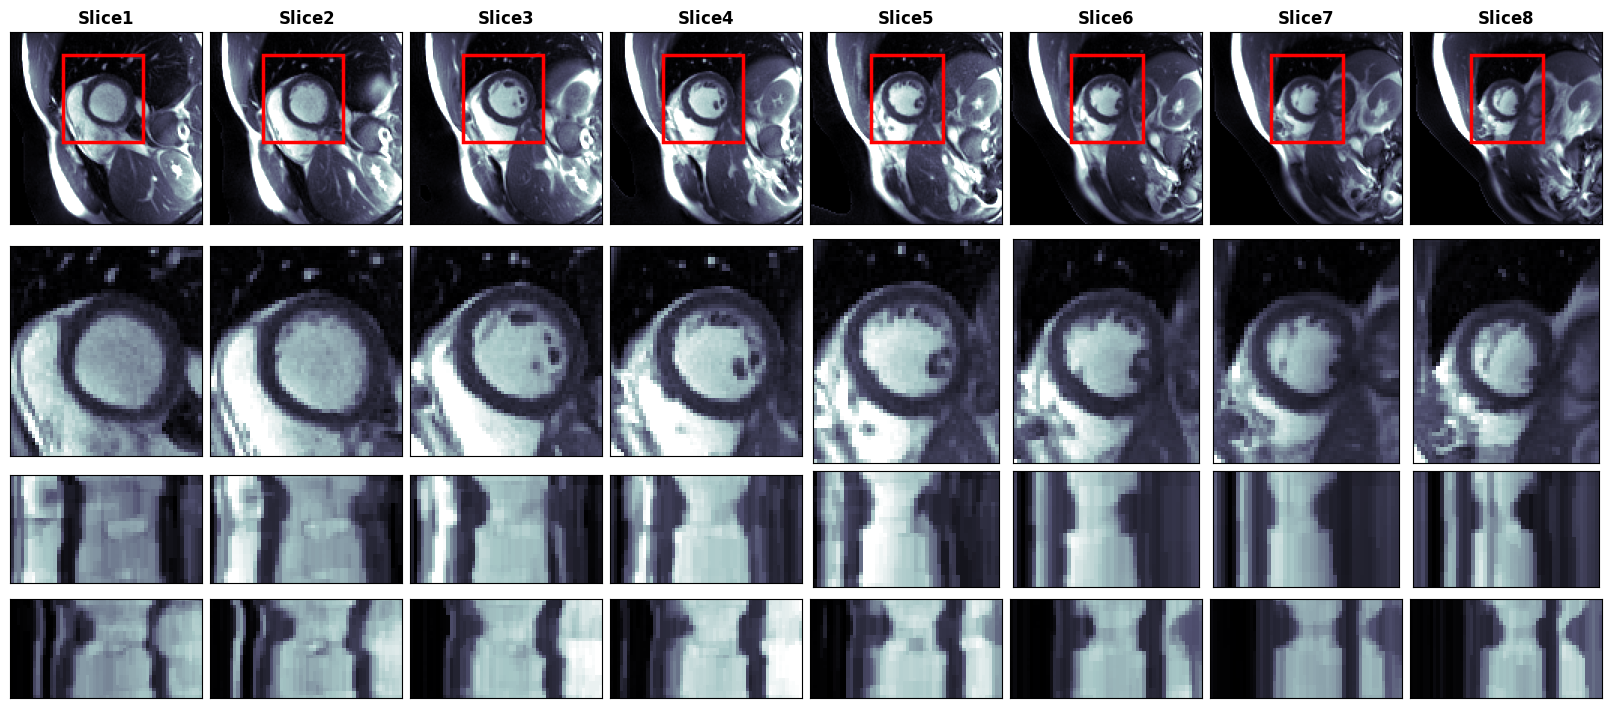

In [10]:
fig, axs = full_halph_FOV_space_time_multislice(fs_list, crop_ns_list=crop_ns_list, saturation_list=saturation_list, frame=frame, xy_proportion=(2,7))
for ax, title in zip(axs, matrix_names):
    ax[0].set_title(title)
fig.savefig( pi_folder + 'all_slices' + '_fs' + ".png", dpi=300, bbox_inches='tight')

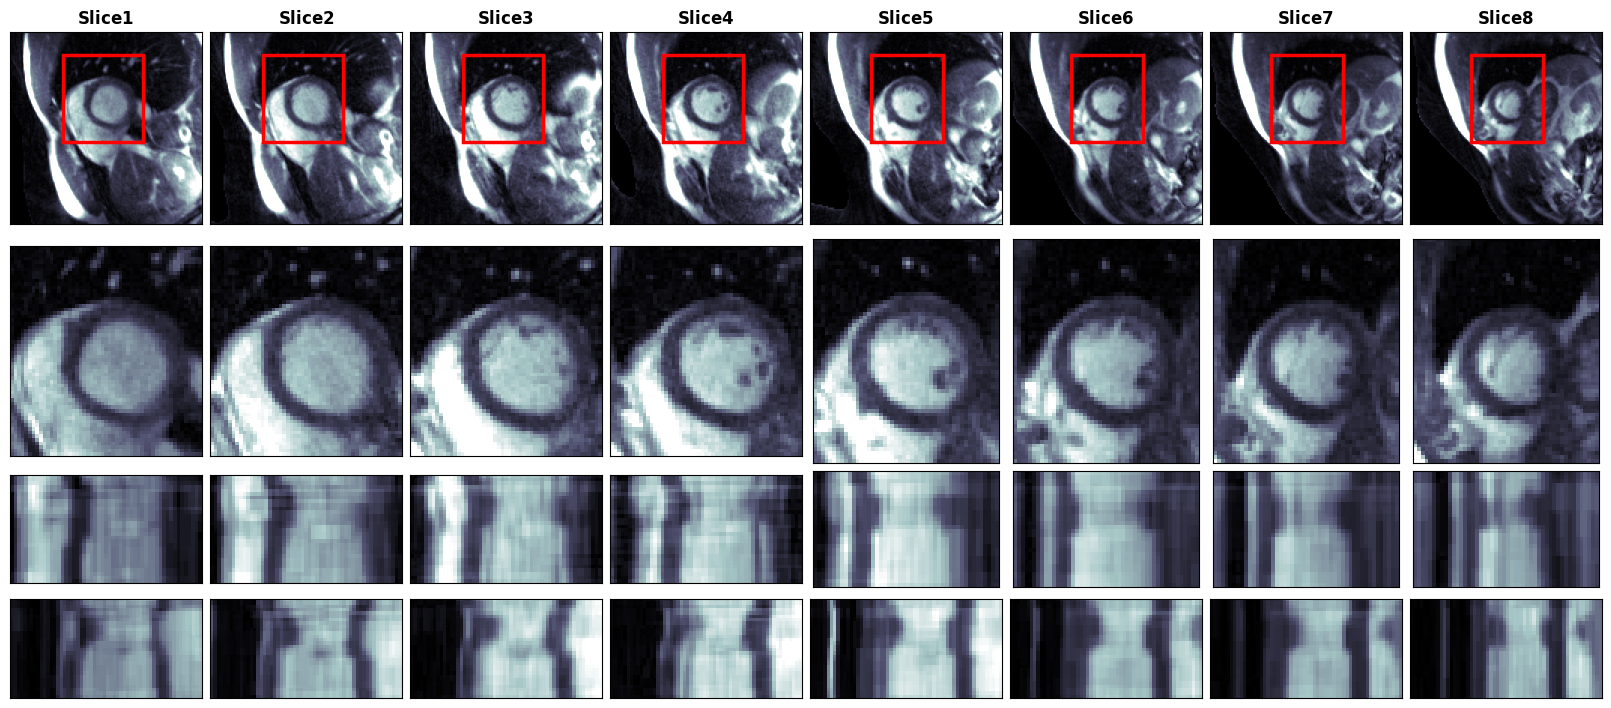

In [11]:
fig, axs = full_halph_FOV_space_time_multislice(grasp_list, crop_ns_list=crop_ns_list, saturation_list=saturation_list, frame=frame, xy_proportion=(2,7))
for ax, title in zip(axs, matrix_names):
    ax[0].set_title(title)
fig.savefig( pi_folder + 'all_slices' + '_grasp' + ".png", dpi=300, bbox_inches='tight')

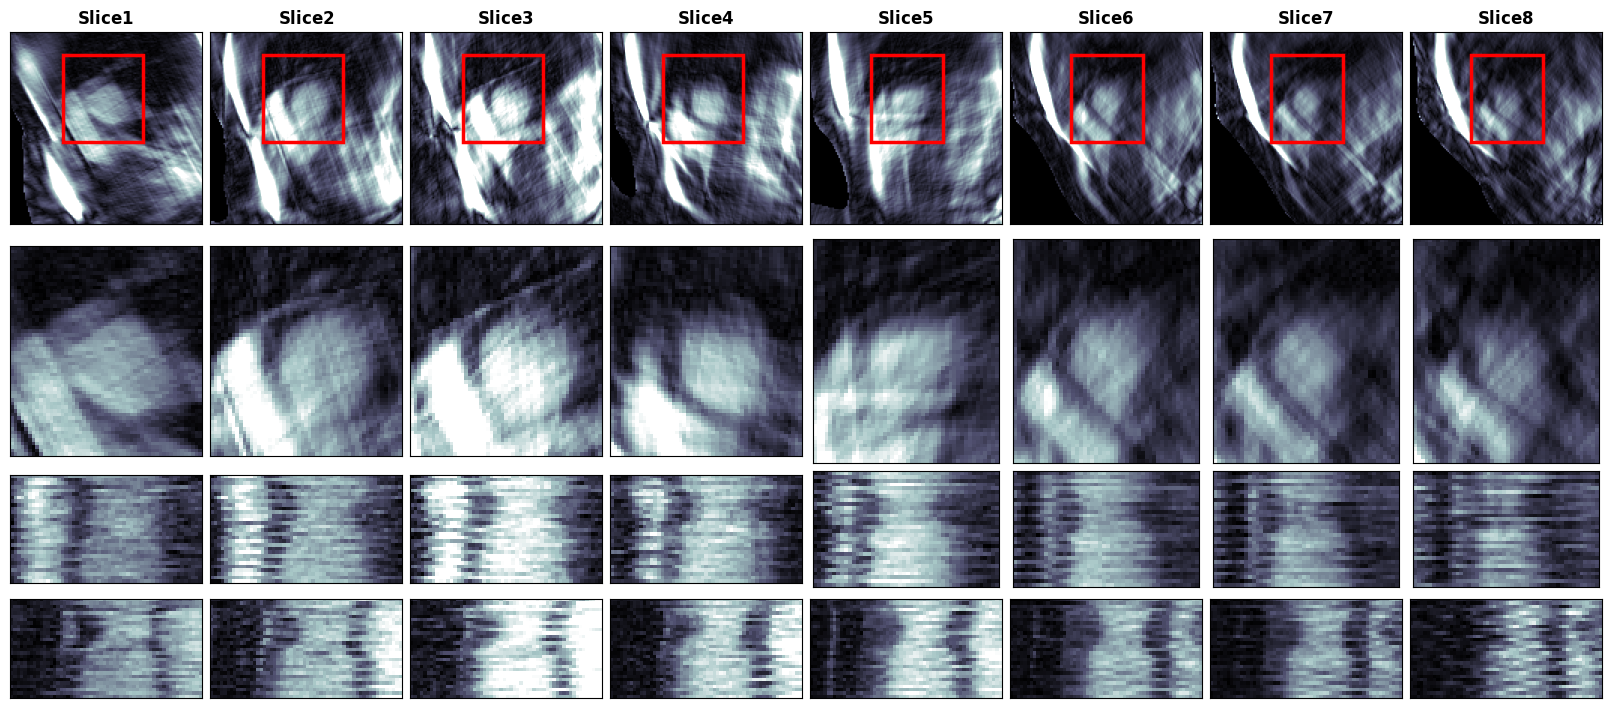

In [12]:
fig, axs = full_halph_FOV_space_time_multislice(sense_list, crop_ns_list=crop_ns_list, saturation_list=saturation_list, frame=frame, xy_proportion=(2,7))
for ax, title in zip(axs, matrix_names):
    ax[0].set_title(title)
fig.savefig( pi_folder + 'all_slices' + '_sense' + ".png", dpi=300, bbox_inches='tight')

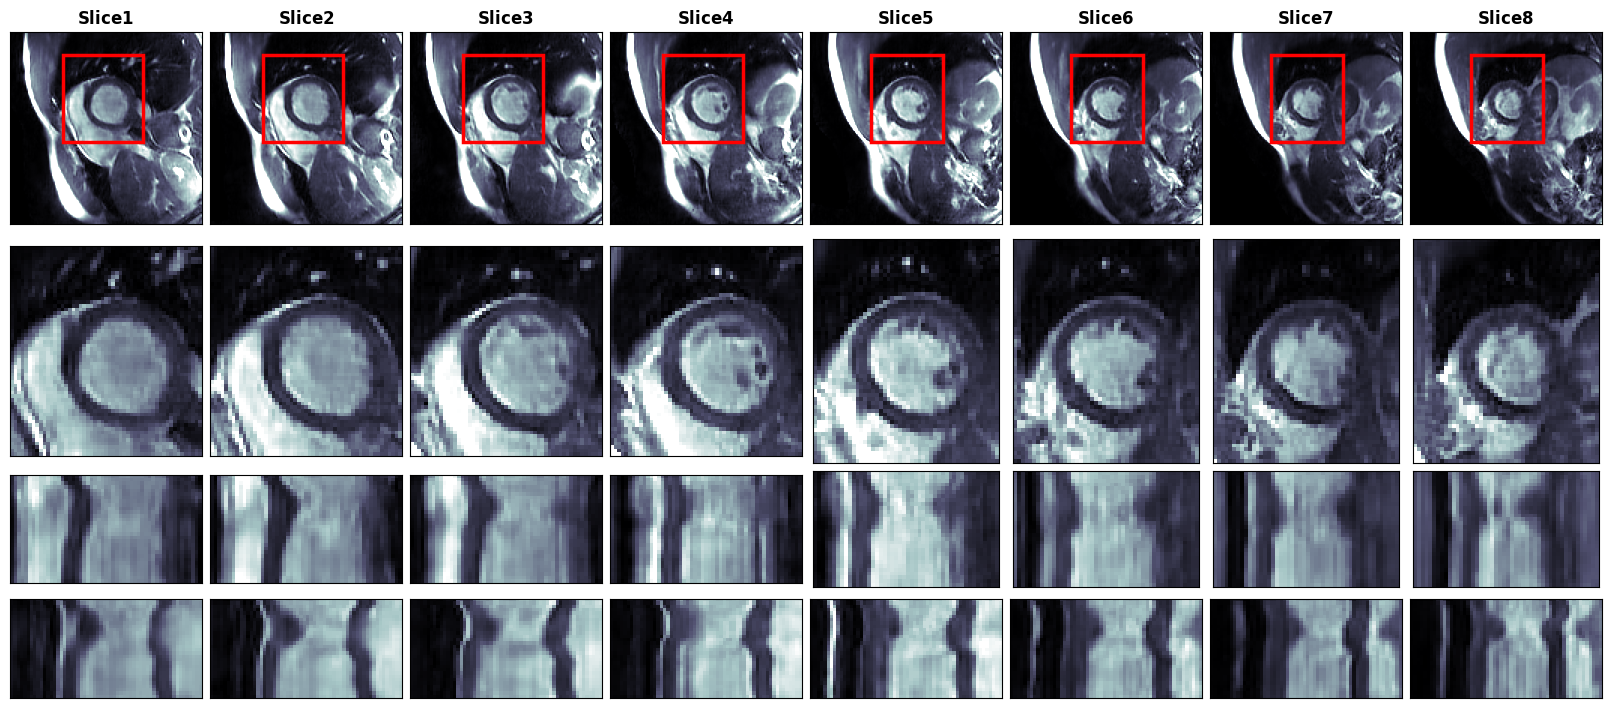

In [13]:
fig, axs = full_halph_FOV_space_time_multislice(stdip_list, crop_ns_list=crop_ns_list, saturation_list=saturation_list, frame=frame, xy_proportion=(2,7))
for ax, title in zip(axs, matrix_names):
    ax[0].set_title(title)
fig.savefig( pi_folder + 'all_slices' + '_stdip' + ".png", dpi=300, bbox_inches='tight')

# **2 .- Best metric plot**